This notebook checks the consistency of batoid and ts_wep.

I take a set of zernikes and create a corresponding perturbed batoid/wfsim simulator. I then simulate a pair of donuts and use ts_wep to estimate the zernikes. I also extract the OPD from batoid. I compare these three sets of zernikes (input, batoid opd, ts_wep estimate) while (1) scaling the zernikes from 0x to 5x, and (2) randomizing the perturbations and the star locations.

Note that I have to debias the batoid OPD so they match the input zernikes. I'm not sure where this bias comes from.

There is some discussion at the bottom.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from lsst.ts.wep.WfEstimator import WfEstimator
from lsst.ts.wep.Utility import DefocalType, getConfigDir

import batoid
import wfsim
import galsim

/astro/store/epyc/projects/lsst_comm/lsstinstall/conda/envs/lsst-scipipe-4.1.0/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


We will have to debias the batoid OPD via $\text{opd} = \text{opd}_\text{orig} @ A$, where @ is matrix multiplication.

The matrix was fit empirically. I checked, and these zernikes do not match any zernike rotation matrices, which are all block diagonal.

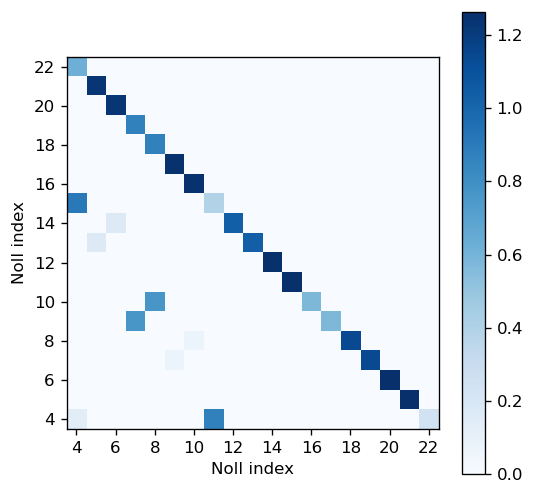

In [103]:
A = np.diag([
    0.6254763780909656,
    1.2307274415082363,
    1.2306909152401038,
    0.866919503599326,
    0.8665062060908879,
    1.251803189305275,
    1.2523544351892006,
    0.3910627006446799,
    1.0327157954667994,
    1.0325354331410224,
    1.2599151511956437,
    1.2578998885805854,
    0.5742296843058615,
    0.5742079418002749,
    1.1372337749101213,
    1.1371773814332429,
    1.2628880527189548,
    1.2624484514547536,
    0.24469739915156496,
])

A[7, 0] = 0.9073309098605322
A[8, 2] = 0.16543401037020986
A[9, 1] = 0.16528221087818903
A[12, 4] = 0.7616296471017431
A[13, 3] = 0.762041366148469
A[14, 6] = 0.07738565346246114
A[15, 5] = 0.07723049699252643
A[18, 0] = 0.1327082222622439
A[18, 7] = 0.8670698596795569

fig, ax = plt.subplots(figsize=(5, 5), dpi=120)

img = ax.imshow(A, extent=(3.5, 22.5, 3.5, 22.5), cmap="Blues")
fig.colorbar(img)

ax.set(
    xlabel="Noll index",
    ylabel="Noll index",
    xticks=np.arange(4, 23, 2), 
    yticks=np.arange(4, 23, 2),
)

plt.show()

I also pulled out a plausible set of zernikes from the zeroth iteration of the phosim closed loop.
These will be used to set the scale for the randomly drawn zernikes below.

In [106]:
zk0 = np.array([
    -0.72299213,
    0.6302713,
    0.7560669,
    -0.04730654,
    0.0045272,
    0.18339995,
    -0.06478361,
    -0.04139484,
    -0.03860196,
    -0.01120152,
    0.1045132,
    0.0418114,
    -0.00260616,
    0.00759261,
    0.02661733,
    -0.02901934,
    0.00955849,
    0.04420937,
    -0.00819899,
])

Setting up the simulations and plotting.

In [2]:
band = "r"

# load the fiducial telescope
telescope = batoid.Optic.fromYaml(f"LSST_{band}.yaml")

# create the wfsim simulator
bandpass = galsim.Bandpass(f"LSST_{band}.dat", wave_type="nm")
observation = {
        'zenith': 30 * galsim.degrees,
        'raw_seeing': 0.7 * galsim.arcsec,  # zenith 500nm seeing
        'wavelength': bandpass.effective_wavelength,
        'exptime': 15.0,  # seconds
        'temperature': 293.,  # Kelvin
        'pressure': 69.,  #kPa
        'H2O_pressure': 1.0  #kPa
    }
atm_kwargs = {
    'screen_size': 819.2,
    'screen_scale': 0.1,
    'nproc': 6  # create screens in parallel using this many CPUs
} 
simulator = wfsim.SimpleSimulator(
    observation,
    atm_kwargs,
    telescope,
    bandpass,
    name="R00_SW0",
    rng=np.random.default_rng(0),
)

In [125]:
detectorLocations = {
    "R00": (-0.02075, -0.02075),
    "R40": (-0.02075, +0.02075),
    "R04": (+0.02075, -0.02075),
    "R44": (+0.02075, +0.02075),
}

In [138]:
def plot(stampExtra, stampIntra, zk, opd, zkEst):
    fig, axes = plt.subplot_mosaic(
        """
        ab
        cc
        """,
        figsize=(4, 4),
        dpi=150,
    )

    axes["a"].imshow(stampIntra, origin="lower")
    axes["a"].set(title="Intra", xticks=[], yticks=[])

    axes["b"].imshow(stampExtra, origin="lower")
    axes["b"].set(title="Extra", xticks=[], yticks=[])

    zk_grid = np.arange(4, 23)
    axes["c"].plot(zk_grid, zk, c="k", label="input")
    axes["c"].plot(zk_grid, opd, ls="--", c="C1", label="batoid OPD")
    axes["c"].plot(zk_grid, zkEst, label="ts_wep")
    axes["c"].legend(fontsize=8)
    axes["c"].set(xticks=np.arange(4, 23, 2), xlabel="Noll index", ylabel="$\mu m$")
    
    plt.show()
    
def random_position(rng):
    # construct the wcs
    simulator._construct_wcs()
    
    # get the bounds, minus a 25% buffer
    bounds = simulator.get_bounds()
    buffer = np.diff(bounds).flatten() / 8
    bounds[:, 0] += buffer
    bounds[:, 1] -= buffer
    
    # select a random position
    thx, thy = rng.uniform(bounds[:, 0], bounds[:, 1])
    
    return thx, thy

def simulate(zk, thx1, thy1, thx2, thy2):
    # check the angles
    assert (np.sign(thx1) == np.sign(thx2)) & (np.sign(thy1) == np.sign(thy2)), "Two stars aren't on same chip!"
    
    # determine the chip
    if thx1 > 0:
        if thy1 > 0:
            chip = "R44"
        else:
            chip = "R04"
    else:
        if thy1 > 0:
            chip = "R40"
        else:
            chip = "R00"
    
    # create the perturbed telescope
    R_outer = telescope.pupilSize / 2
    R_inner = R_outer * telescope.pupilObscuration
    phase = batoid.Zernike(
        np.pad(zk, pad_width=(4,0), mode='constant') * 1e-6,
        R_outer=R_outer,
        R_inner=R_inner,
    )
    perturbed = batoid.CompoundOptic(
            (
                batoid.optic.OPDScreen(
                    batoid.Plane(),
                    phase,
                    name="PhaseScreen",
                    obscuration=batoid.ObscNegation(batoid.ObscCircle(5.0)),
                    coordSys=telescope.stopSurface.coordSys
                ),
                *telescope.items,
            ),
            name="PerturbedLSST",
            backDist=telescope.backDist,
            pupilSize=telescope.pupilSize,
            inMedium=telescope.inMedium,
            stopSurface=telescope.stopSurface,
            sphereRadius=telescope.sphereRadius,
            pupilObscuration=telescope.pupilObscuration
    )
    
    # setup WfEstimator
    wfEst = WfEstimator(f"{getConfigDir()}/cwfs/algo")
    wfEst.config(sizeInPix=160, units="um", algo="exp", debugLevel=1)
    
    # set some star settings
    T = 7_000 # K
    nphotons = 1_000_000
    
    # create the extrafocal simulator
    simulator.set_name(f"{chip}_SW0")
    simulator.telescope = perturbed.withGloballyShiftedOptic(
        "Detector", [0, 0, +0.0015]
    )
    
    # simulate the star
    simulator.add_star(thx1, thy1, wfsim.BBSED(T), nphotons, rng)

    # cut out the extrafocal stamp
    simulator._construct_wcs()
    x, y = np.array(simulator.wcs.radecToxy(thx1, thy1, galsim.radians))
    x = int(x - simulator.image.xmin)
    y = int(y - simulator.image.ymin)
    stampExtra = simulator.image.array[y-80:y+80, x-80:x+80]
    
    # add extrafocal sim to WfEstimator
    wfEst.setImg(
        np.rad2deg([thx1, thy1]),
        DefocalType.Extra,
        image=stampExtra,
    )
    
    # create the intrafocal simulator
    simulator.set_name(f"{chip}_SW1")
    simulator.telescope = perturbed.withGloballyShiftedOptic(
        "Detector", [0, 0, -0.0015]
    )
    
    # simulate the star
    simulator.add_star(thx2, thy2, wfsim.BBSED(T), nphotons, rng)

    # cut out the intrafocal stamp
    simulator._construct_wcs()
    x, y = np.array(simulator.wcs.radecToxy(thx2, thy2, galsim.radians))
    x = int(x - simulator.image.xmin)
    y = int(y - simulator.image.ymin)
    stampIntra = simulator.image.array[y-80:y+80, x-80:x+80]
    
    # add intrafocal sim to WfEstimator
    wfEst.setImg(
        np.rad2deg([thx2, thy2]),
        DefocalType.Intra,
        image=stampIntra,
    )
    
    # estimate the wavefront
    zkEst = -wfEst.calWfsErr()
    
    # get true OPD from batoid
    opd = batoid.zernike(
        perturbed,
        *detectorLocations[chip],
        1e-6,
        jmax=22,
    ) - batoid.zernike(
        telescope,
        *detectorLocations[chip],
        1e-6,
        jmax=22,
    )
    
    # debias the opd
    opd = -opd[4:] @ A
    
    plot(stampExtra, stampIntra, zk, opd, zkEst)
    
    return zk, opd, zkEst

def random_simulation(rng):
    # draw a random set of zernikes
    zk = rng.normal(scale=np.abs(zk0))
    
    # randomly select a chip
    chip = rng.choice(["R00", "R40", "R44", "R04"])
    
    # select extrafocal star position
    simulator.set_name(f"{chip}_SW0")
    thx1, thy1 = random_position(rng)
    
    # select intrafocal star position
    simulator.set_name(f"{chip}_SW1")
    thx2, thy2 = random_position(rng)
    
    return simulate(zk, thx1, thy1, thx2, thy2)

## Check consistency while scaling zernikes from 0x to 5x

Note I keep the star positions the same throughout.

In [140]:
thx1, thy1 = 0.019, -0.019 # extrafocal angle (radians)
thx2, thy2 = 0.022, -0.020 # intrafocal angle (radians)

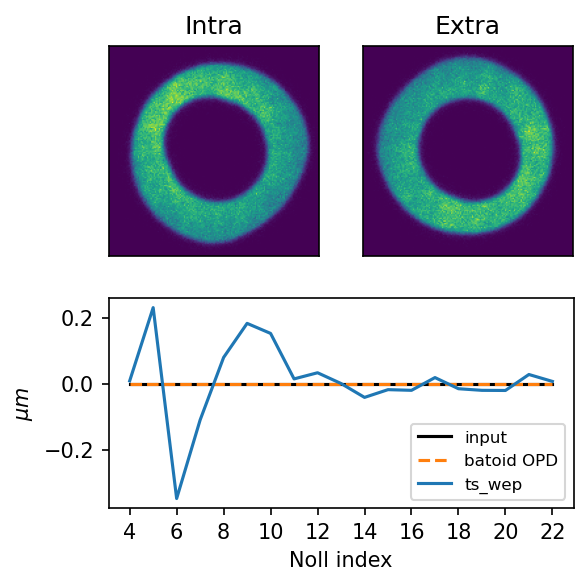

In [142]:
zk00, opd00, zkEst00 = simulate(0.0 * zk0, thx1, thy1, thx2, thy2)

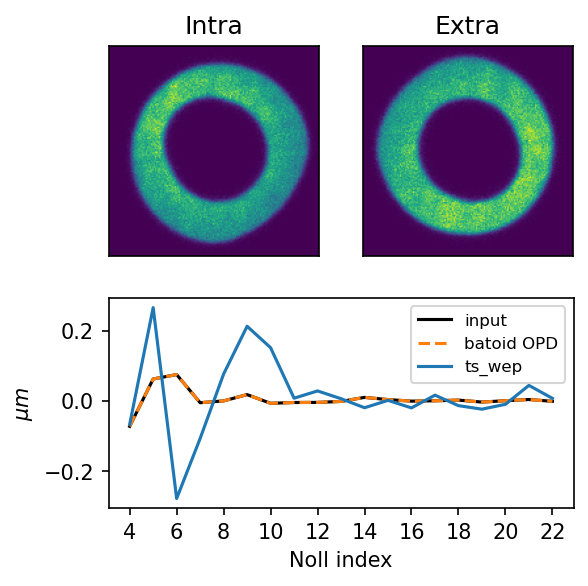

In [143]:
zk01, opd01, zkEst01 = simulate(0.1 * zk0, thx1, thy1, thx2, thy2)

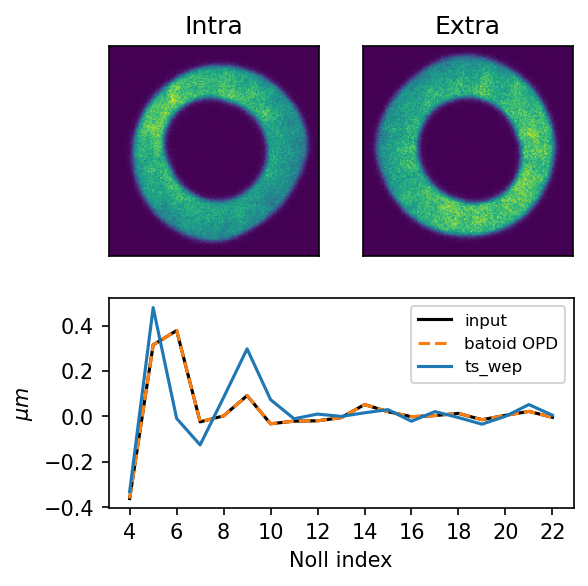

In [144]:
zk05, opd05, zkEst05 = simulate(0.5 * zk0, thx1, thy1, thx2, thy2)

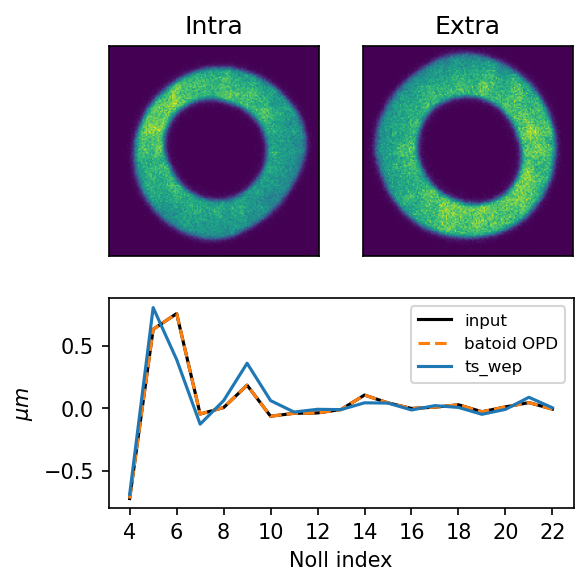

In [145]:
zk10, opd10, zkEst10 = simulate(1.0 * zk0, thx1, thy1, thx2, thy2)

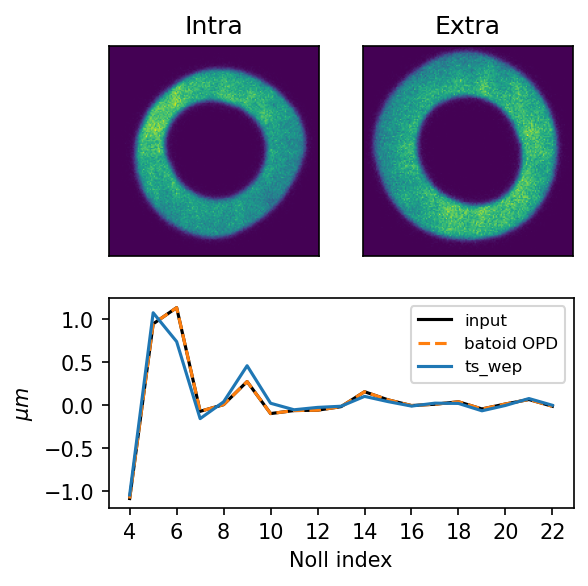

In [146]:
zk15, opd15, zkEst15 = simulate(1.5 * zk0, thx1, thy1, thx2, thy2)

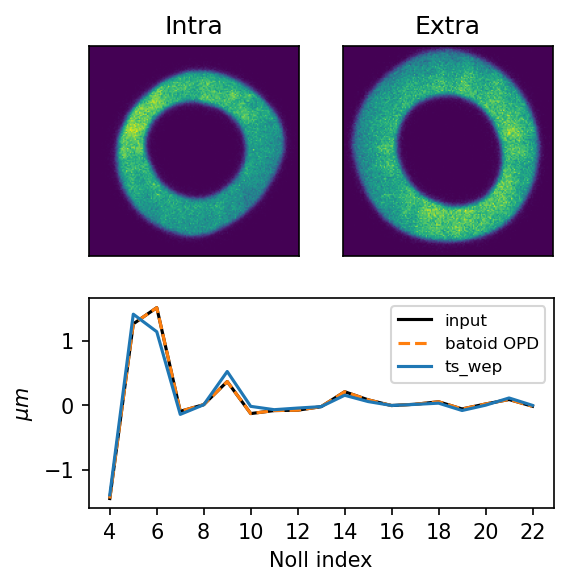

In [147]:
zk20, opd20, zkEst20 = simulate(2.0 * zk0, thx1, thy1, thx2, thy2)

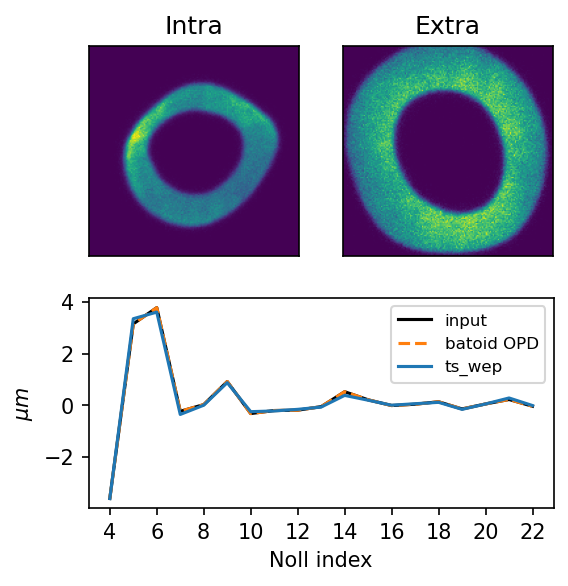

In [148]:
zk50, opd50, zkEst50 = simulate(5.0 * zk0, thx1, thy1, thx2, thy2)

## Check consistency while randomizing zernikes and star locations

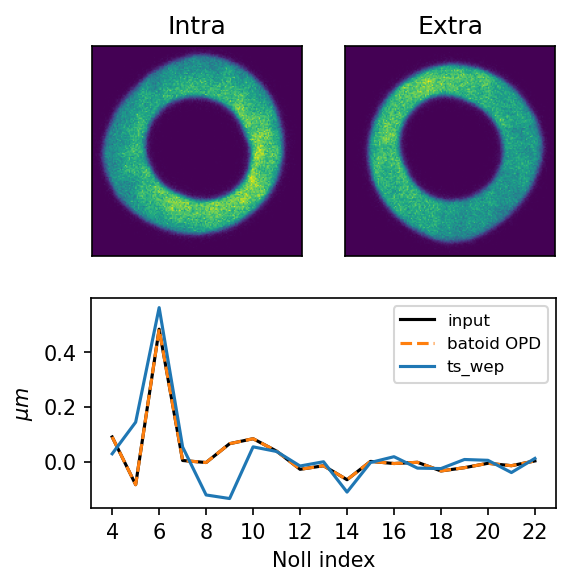

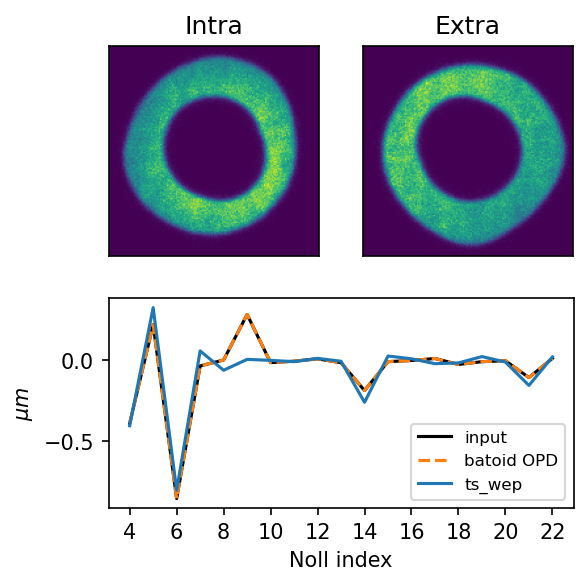

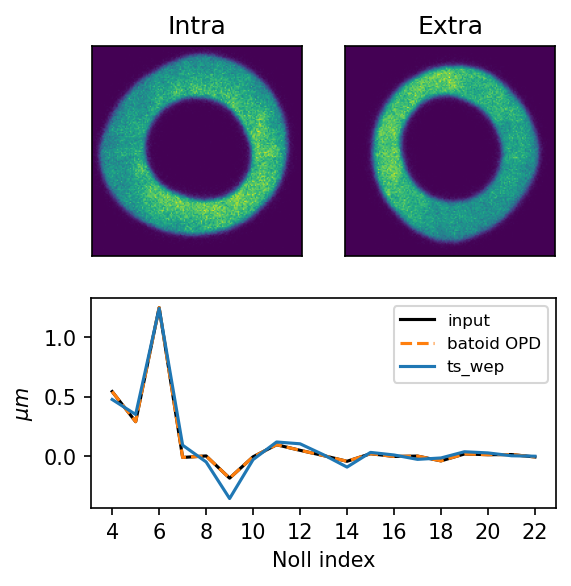

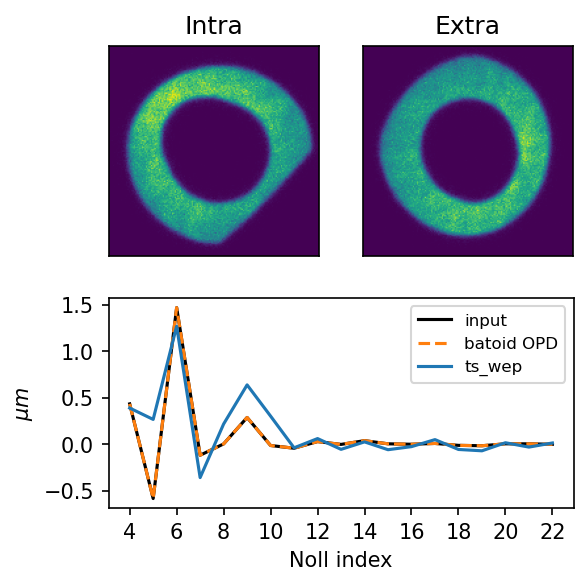

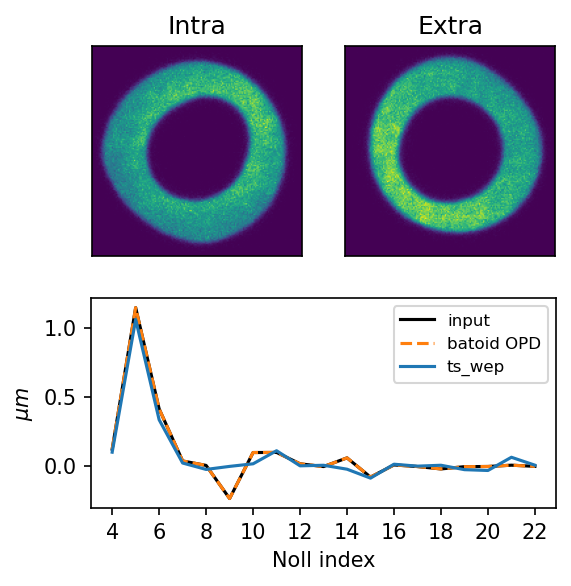

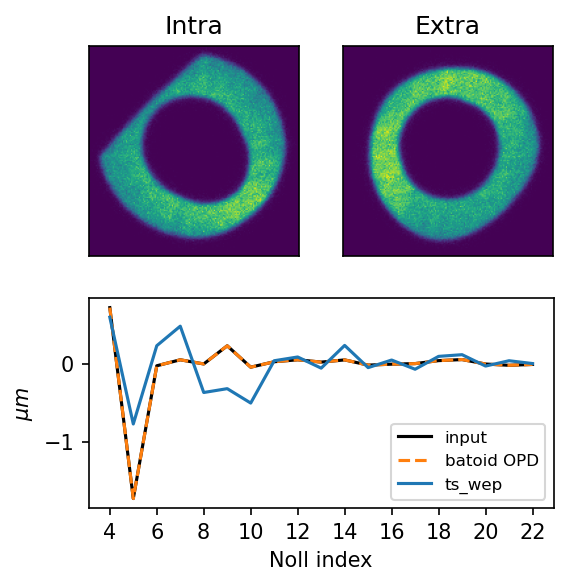

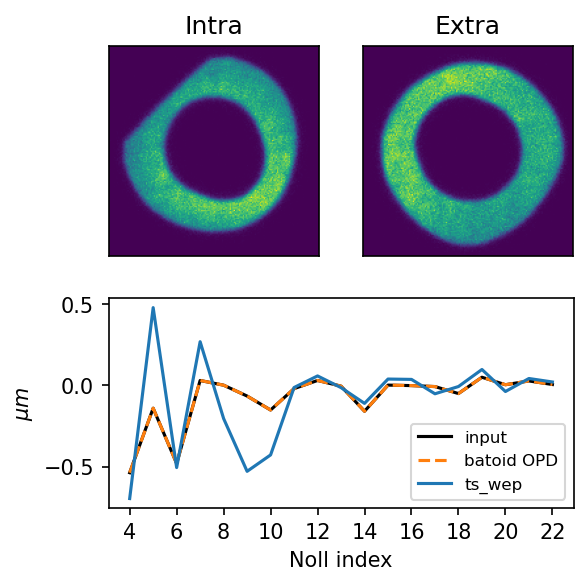

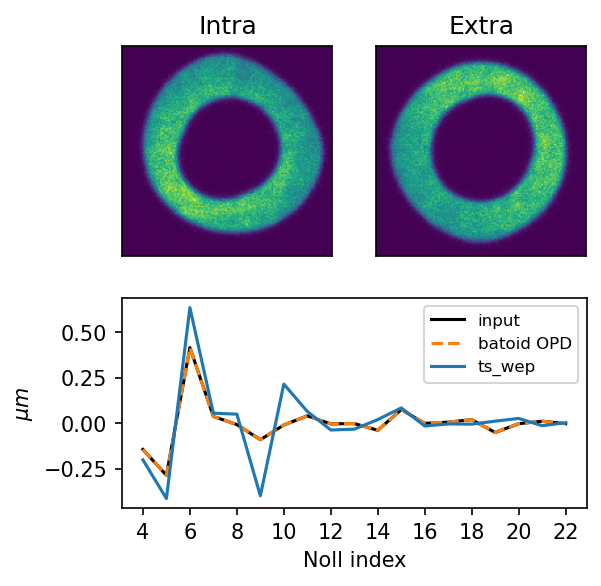

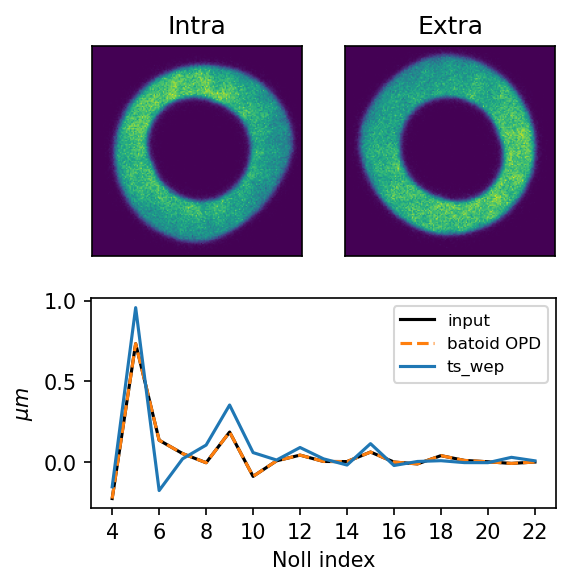

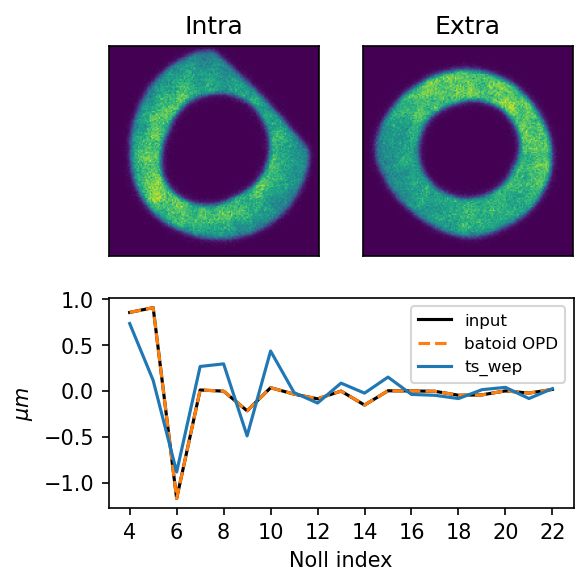

In [139]:
rng = np.random.default_rng(0)

for i in range(10):
    random_simulation(rng)

### Discussion:

- After debiasing, the input zernikes and batoid OPD always agree
- I do not know where the bias comes from. It is not from a zernike rotation.
- ts_wep struggles to estimate zernikes for small perturbations. 
- As the zernike magnitudes are increased, ts_wep converges on the truth